<h1>Precision @ K Evaluation</h1>

**NASA Impact Hurricane data**

# Imports


In [52]:
import os
from os import path
import sys
import math
import cv2 # Read raw image
import glob
import random
import numpy as np
import pickle
from matplotlib import pyplot as plt
from scipy import ndimage # For rotation task or
import imutils
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
from skimage.transform import resize
from pprint import pprint
from tqdm import tqdm, tqdm_notebook

import time
import PIL
from PIL import Image
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

import matplotlib
import matplotlib.image as mpimg

import tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.utils import data_utils
from tensorflow.keras.preprocessing.image import Iterator
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, AveragePooling2D, MaxPooling2D, Reshape, Conv2DTranspose, ZeroPadding2D, Add
from tensorflow.keras.layers import Activation, InputLayer, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import PReLU

sys.path.append("/home/satyarth934/code/FDL_2020/training_scripts")
import utils

# # Check to see if GPU is being used
# print(tensorflow.test.gpu_device_name())
# print("Num GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [53]:
MODEL_NAME = "baseAE_hurricane_try3"
BASE_DIR = "/home/satyarth934/code/FDL_2020/"

FEATURE_DIR = BASE_DIR + "Features/" + MODEL_NAME
PATH_LIST = FEATURE_DIR + "/filenames.pkl"
FEATURES_OUTPUT = FEATURE_DIR + "/features.pkl"
P_AT_K_PLOT =  FEATURE_DIR + "/windspeed_abs_error_plot_2_to_10.png"

# MODIS_DUST_GT_PATH = "/home/satyarth934/data/modis_data_products/MODIS_Dust_Events_2010_2020_h16v7.pkl"
# DUST_GT = pickle.load(open(MODIS_DUST_GT_PATH, 'rb'))

dims = (448,448,3)

filenames = pickle.load(open(PATH_LIST,'rb'))
feature_list = pickle.load(open(FEATURES_OUTPUT, 'rb'))

In [54]:
num_images = len(filenames)
num_features_per_image = len(feature_list[0])
print("Number of images = ", num_images)
print("Number of features per image = ", num_features_per_image)

Number of images =  1069
Number of features per image =  3920


In [55]:
len(feature_list)

1069

In [56]:
def getWindSpeed(str):    
    file_name = str.split("/")[-1]
    wind_speed = int(file_name.split(".")[0].split("_")[-1].strip("kts"))
    return wind_speed


# compute the absolute error in the windspeed of query image and the similar images
def calculate_abserr_windspeed(feature_list, num_nearest_neighbors):
    mae = []
    neighbors = NearestNeighbors(n_neighbors=num_nearest_neighbors,
                                 algorithm='brute',
                                 metric='euclidean').fit(feature_list)
    for i in tqdm_notebook(range(len(feature_list))):
        distances, indices = neighbors.kneighbors([feature_list[i]])
        for j in range(1, num_nearest_neighbors):
            query_ws = getWindSpeed(filenames[i])
            sim_ws = getWindSpeed(filenames[indices[0][j]])
            abs_err = abs(query_ws - sim_ws)
            
            mae.append(abs_err)
    
    print("Mean AE for %d neighbors:" % (num_nearest_neighbors), np.mean(mae))
    print("Median AE for %d neighbors:" % (num_nearest_neighbors), np.median(mae))
    
    return (np.mean(mae), np.median(mae))

In [57]:
# Select the number of neighbors to check for accuracy measurement
num_neighbor_check = [2,3,4]
# num_neighbor_check = [2,3,4,5,10,20,30,40,50]
# num_neighbor_check = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 35, 40, 45, 50]
# num_neighbor_check = [2, 3, 4, 5, 6, 7, 8, 9, 10]

ws_mean_ae = []
ws_median_ae = []
errs_gt_median = []
for num_neighbor in num_neighbor_check:
    print(num_neighbor)
    ws_mean_e, ws_median_e = calculate_abserr_windspeed(feature_list, num_neighbor)
    ws_mean_ae.append(ws_mean_e)
    ws_median_ae.append(ws_median_e)


2


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]



Mean AE for 2 neighbors: 4.396632366697848
Median AE for 2 neighbors: 0.0
3


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]



Mean AE for 3 neighbors: 6.414873713751169
Median AE for 3 neighbors: 0.0
4


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]



Mean AE for 4 neighbors: 7.949797318366074
Median AE for 4 neighbors: 5.0


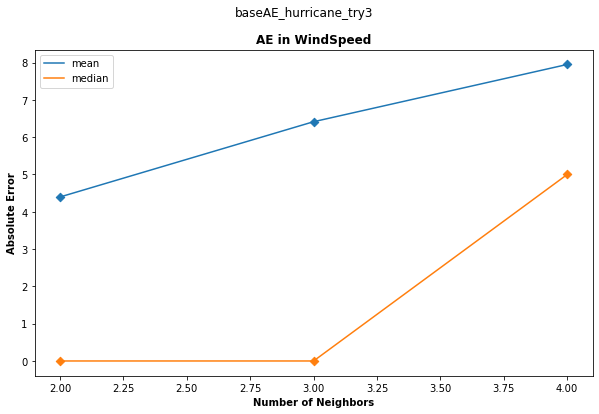

In [58]:
# Individual classes + Combined All classes
plt.figure(figsize=(10,6))
plt.suptitle(MODEL_NAME)
# plt.xticks(np.arange(2, 51, 2))
plt.xlabel('Number of Neighbors', fontweight='bold')
plt.ylabel('Absolute Error', fontweight='bold')
plt.title('AE in WindSpeed', fontweight='bold')

plt.scatter(num_neighbor_check, ws_mean_ae, marker='D')
plt.plot(num_neighbor_check, ws_mean_ae)

plt.scatter(num_neighbor_check, ws_median_ae, marker='D')
plt.plot(num_neighbor_check, ws_median_ae)

plt.legend(labels=["mean", "median"], loc='upper left')

# plt.savefig(P_AT_K_PLOT)
# plt.savefig(P_AT_K_PLOT.replace(".png", ".eps"))